# Practical Three: Panoramas (Features and Matching)

This notebook is prepared to introduce you to the basics of how to create image panoramas including finding keypoints in an image, describing those key points, matching them to those points in another image, computing the transform from one image to the other, and stitching them together into a panorama.


### References
* [Based on "Homework 2: Panoramas!"](https://github.com/pjreddie/vision-hw2)
* [Lecture 6: Features and Matching](https://docs.google.com/presentation/d/11f77YuX5YVUmhr1QWYGCSmg5lHyml0VaRjDh93aceHI/edit?usp=sharing) and [Lecture 7: Matching, RANSAC, SIFT, and HoG](https://docs.google.com/presentation/d/1QgLpO6-fOn14dGbyPXidGolOEX6G3yFZc3UAXeALnek/edit?usp=sharing)

## Load Required Modules

In [1]:
from PIL import Image, ImageDraw
from IPython.display import display
import numpy as np
import matplotlib.pyplot as pl

In [2]:
def np2img(im, norm=False, rgb_mode=False):
    """
    This function converts the input numpy object im to Image object and returns
    the converted object. If norm == True, then the input is normalised to [0,1]
    using im <- (im - im.min()) / (im.max() - im.min()).
    """
    if norm:
        if ((im.max() - im.min()) != 0.0):
            im = (im - im.min()) / (im.max() - im.min())

    if ((im.min() >= 0.0) and (im.max() <= 1.0)):
        im = im * 255.0

    if rgb_mode and im.ndim == 2:
        im = im[...,np.newaxis].repeat(3, axis=2)
        
    if im.ndim == 2:
        im = Image.fromarray(im.astype(np.uint8), mode='L')
    elif (im.ndim == 3) and (im.shape[2] == 3):
        im = Image.fromarray(im.astype(np.uint8), mode='RGB')

    return im

def draw_corners(im, points, line_length=7, line_width=1, color=(255, 0, 0)):
    """
    This function draws a cross at each point (x,y) of the input points list 
    on the input image object im.
    """
    im = im.copy()
    draw = ImageDraw.Draw(im)
    for point in points:
        x, y = point[0], point[1]
        
        if ((x-line_length) >= 0):
            left = ((x-line_length), y)
        else:
            left = (0, y)
        
        if ((x+line_length) < im.size[0]):
            right = ((x+line_length), y)
        else:
            right = (im.size[0]-1, y)

        if ((y-line_length) >= 0):
            top = (x, (y-line_length))
        else:
            top = (x, 0)

        if ((y+line_length) < im.size[1]):
            bottom = (x, (y+line_length))
        else:
            bottom = (x, im.size[1]-1)
        
        draw.line(left + right, fill=color, width=line_width)
        draw.line(top + bottom, fill=color, width=line_width)

    return im

def imresize_nn(im, width, height, img_obj=False):
    """
    This function resizes the input Image object im to the size of (width x height)
    pixels based on the nearest neigbor interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object
    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1] - 0.5) - (-0.5)) / ((im_res.shape[1] - 0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        a_y = ((im.shape[0] - 0.5) - (-0.5)) / ((im_res.shape[0] - 0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)

        # Create a lookup table for speeding up the operations
        y_im = np.zeros(im_res.shape[0], dtype=np.int32)
        for i in range(im_res.shape[0]):
            y_im[i] = int(np.round(a_y * i + b_y))
            if y_im[i] < 0:
                y_im[i] = 0
            if y_im[i] > (im.shape[0] - 1):
                y_im[i] = im.shape[0] - 1

        x_im = np.zeros(im_res.shape[1], dtype=np.int32)
        for i in range(im_res.shape[1]):
            x_im[i] = int(np.round(a_x * i + b_x))
            if x_im[i] < 0:
                x_im[i] = 0
            if x_im[i] > (im.shape[1] - 1):
                x_im[i] = im.shape[1] - 1
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                im_res[y, x] = im[y_im[y], x_im[x]]

    if img_obj:
        im_res = np2img(im_res)

    return im_res


def imresize_bi(im, width, height, img_obj=False):
    """
    This function resizes the input Image object im to the size of (width x height) 
    pixels based on the bilinear interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object

    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1]-0.5) - (-0.5)) / ((im_res.shape[1]-0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        
        a_y = ((im.shape[0]-0.5) - (-0.5)) / ((im_res.shape[0]-0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)
        
        # Create a lookup table for speeding up the operations
        y_im = np.zeros((im_res.shape[0], 2), dtype=np.int32)
        y_im_d = np.zeros((im_res.shape[0], 2), dtype=np.float32)
        for i in range(im_res.shape[0]):
            y_im_ = a_y * i + b_y
            # Take care of the boundary cases
            if y_im_ < 0.0:
                y_im_ = np.abs(y_im_)
            if y_im_ > (im.shape[0]-1):
                y_im_ = (im.shape[0]-1) - (y_im_-(im.shape[0]-1))
            # Compute the mapping in the input image coordinate
            y_im[i,0] = int(np.floor(y_im_))
            y_im[i,1] = int(np.ceil(y_im_))
            y_im_d[i,0] = y_im[i,1] - y_im_
            y_im_d[i,1] = y_im_ - y_im[i,0]
            

        x_im = np.zeros((im_res.shape[1], 2), dtype=np.int32)
        x_im_d = np.zeros((im_res.shape[1], 2), dtype=np.float32)
        for i in range(im_res.shape[1]):
            x_im_ = a_x * i + b_x
            # Take care of the boundary cases
            if x_im_ < 0.0:
                x_im_ = np.abs(x_im_)
            if x_im_ > (im.shape[1]-1):
                x_im_ = (im.shape[1]-1) - (x_im_-(im.shape[1]-1))
            # Compute the mapping in the input image coordinate
            x_im[i,0] = int(np.floor(x_im_))
            x_im[i,1] = int(np.ceil(x_im_))
            x_im_d[i,0] = x_im[i,1] - x_im_
            x_im_d[i,1] = x_im_ - x_im[i,0]
        
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                if (x_im[x,0] == x_im[x,1]) and (y_im[y,0] == y_im[y,1]):
                    q = im[y_im[y,0], x_im[x,0]]
                elif (x_im[x,0] == x_im[x,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v3 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * y_im_d[y,0] + v3 * y_im_d[y,1]
                elif (y_im[y,0] == y_im[y,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * x_im_d[x,0] + v2 * x_im_d[x,1]
                else:
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,0], x_im[x,1]]
                    v3 = im[y_im[y,1], x_im[x,0]]
                    v4 = im[y_im[y,1], x_im[x,1]]
                    q1 = v1 * x_im_d[x,0] + v2 * x_im_d[x,1]
                    q2 = v3 * x_im_d[x,0] + v4 * x_im_d[x,1]
                    q = q1 * y_im_d[y,0] + q2 * y_im_d[y,1]
    
                im_res[y, x] = q

    if img_obj:
        im_res = np2img(im_res)
    
    return im_res


def imfilter(im, filter, preserve=False, img_obj=False, mode='edge'):
    """
    This function filters the input object im with the numpy array filter and 
    returns the filtered image object.
    """
    # Convert the input object to numpy array object
    im = np.array(im).astype(float)
    if (im.ndim == 2):
        im = im[...,np.newaxis]
    # Get the filter dimensions
    h, w = filter.shape[:2][0] // 2, filter.shape[:2][1] // 2
    if (filter.ndim == 2):
        filter = filter[...,np.newaxis]
    # Apply padding on the input image to handle image boundaries
    pad_width = [[h,h],[w,w]]
    for d in range(2, im.ndim):
        pad_width.append([0,0])
    im = np.pad(im, pad_width=pad_width, mode=mode)
    # Create place holder for the filtered image
    if preserve:
        im_ = im.copy()
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum(axis=(0,1))
    else:
        im_ = np.zeros(im.shape[:2])
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum()

    # Exclude the boundary pixels
    im = im_[h:im.shape[0]-h, w:im.shape[1]-w]

    if img_obj:
        im = np2img(im)
    
    return im


def box_filter(width, height, channel=1):
    """
    This function creates and returns a numpy array of size (height x width) with all entries equal to 1/(height x width x channel). 
    If any of input parameters width and height is an even number, then it is rolled up to the nearest
    odd number. Note that if channel > 1, then the returned array will be of dimensions (height x width x channel).
    """
    if (width % 2) == 0:
        width += 1
    if (height % 2) == 0:
        height += 1

    if channel > 1:
        data = np.ones((height, width, channel)) / (height * width * channel)
    else:
        data = np.ones((height, width)) / (height * width)

    return data


def gaussian_kernel(sigma, dim=1):
    """
    This function generates and returns either a 1D (dim=1) or 2D (dim=2)
    Gaussian kernel with a standard deviation sigma. Note that the function
    automatically adjusts the kernel size so that 99% of the distribution falls 
    within 3 standard deviations.
    """
    k = int(2 * np.ceil(3*sigma) + 1)
    x = np.linspace(-3*sigma, 3*sigma, k)
    g = 1.0 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-x**2/(2*sigma**2))
    g = g / g.sum()
    g = g[np.newaxis,...]
    if dim == 2:
        g = np.dot(g.T, g)
        
    return g

## Harris Corner (Keypoint) Detection

Harris corner detection on the input grayscale image $I$ can be performed as follows:
- Calculate image derivatives $I_{x}$ and $I_{y}$;
- Calculate three measures $I_{x}I_{x}$, $I_{y}I_{y}$, and $I_{x}I_{y}$;
- Calculate structure matrix ($S$) components as weighted sum of nearby measures;
- Calculate Harris "cornerness" response map as estimate of the 2nd eigenvalue: det($S$)- $\alpha$ trace($S$)$^2$, $\alpha = .06$; and
- Run non-max suppression on the response map.

Harris corner detection operates on grayscale (or 2D) images, not on color (or 3D) images. As such, we need to convert the input color image to a grayscale image before we apply any operations. One easy way of doing this is by applying a weighted filter $F$ of size $1 \times 1 \times 3$ on the input color image to produce a grayscale image $I$.

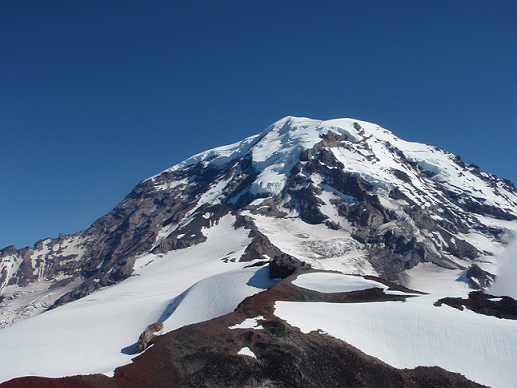

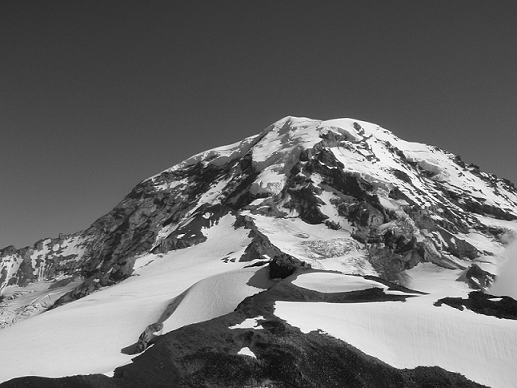

In [3]:
# Load an RGB (or color) image. 
# Note that PNG files may load with a transparency (or alpha) channel,
# which should be removed (hence applying .convert('RGB')).
RGB = Image.open('../data/Rainier1.png').convert('RGB')
display(RGB)
# Convert the loaded RGB image to a grayscale image.
F = np.array([[[0.299, 0.587, 0.114]]])
I = imfilter(RGB, F) / 255.0
display(np2img(I))

Now we can calculate image derivatives $I_{x}$ and $I_{y}$.

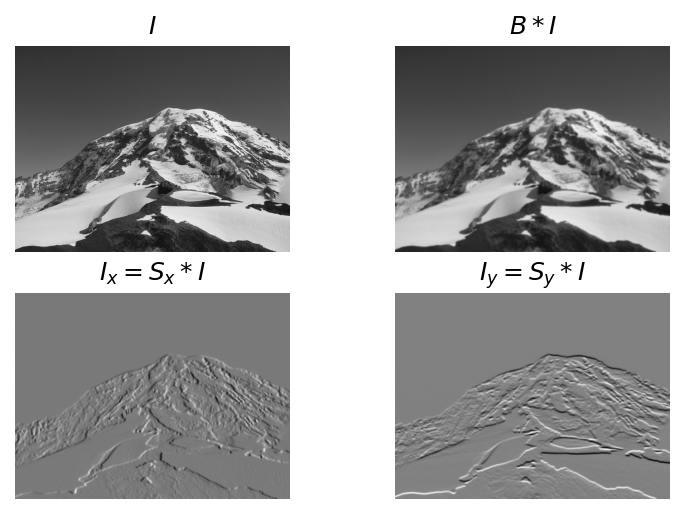

In [4]:
B = gaussian_kernel(sigma=1, dim=2)
Sx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Sy = Sx.copy().T

IB = imfilter(I, B)
Ix = imfilter(IB, Sx)
Iy = imfilter(IB, Sy)

f, axes = pl.subplots(2,2, dpi=150)
axes[0,0].imshow(np2img(I,False,True))
axes[0,0].axis(False)
axes[0,0].set_title('$I$')

axes[0,1].imshow(np2img(IB,False,True))
axes[0,1].axis(False)
axes[0,1].set_title('$B * I$')

axes[1,0].imshow(np2img(Ix,True,True))
axes[1,0].axis(False)
axes[1,0].set_title('$I_{x} = S_x * I$')

axes[1,1].imshow(np2img(Iy,True,True))
axes[1,1].axis(False)
axes[1,1].set_title('$I_{y} = S_y * I$');

Now, we can calculate three measures $I_{x}I_{x}$, $I_{y}I_{y}$, and $I_{x}I_{y}$.

In [5]:
IxIx = Ix * Ix
IyIy = Iy * Iy
IxIy = Ix * Iy

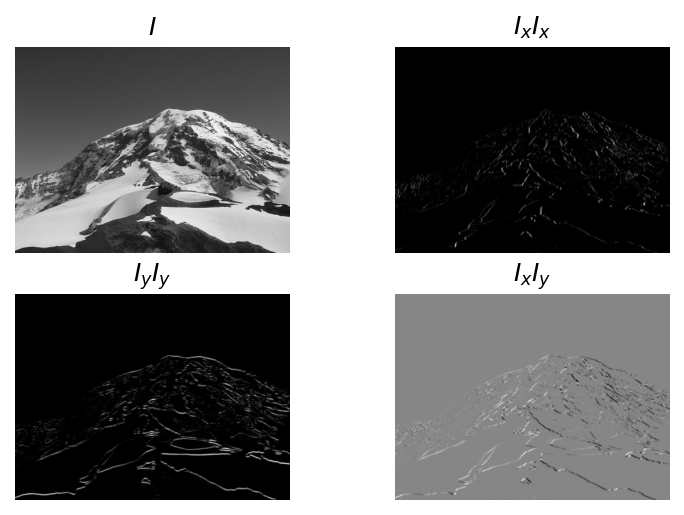

In [6]:
f, axes = pl.subplots(2,2, dpi=150)
axes[0,0].imshow(np2img(I,False,True))
axes[0,0].axis(False)
axes[0,0].set_title('$I$')

axes[0,1].imshow(np2img(IxIx,True,True))
axes[0,1].axis(False)
axes[0,1].set_title('$I_{x}I_{x}$')

axes[1,0].imshow(np2img(IyIy,True,True))
axes[1,0].axis(False)
axes[1,0].set_title('$I_{y}I_{y}$')

axes[1,1].imshow(np2img(IxIy,True,True))
axes[1,1].axis(False)
axes[1,1].set_title('$I_{x}I_{y}$');

Now, we can calculate structure matrix ($S$) components as weighted sum of nearby measures. The weighted sum of nearby measures can be easily computed with a Gaussian blur.

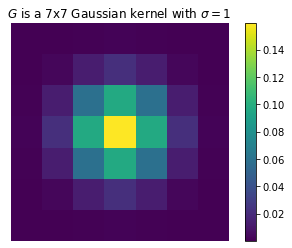

In [7]:
sigma = 1
G = gaussian_kernel(sigma, dim=2)
pl.figure()
pl.imshow(G)
pl.colorbar()
pl.axis(False)
pl.title(
    '$G$ is a {0}x{1} Gaussian kernel with $\sigma={2}$'
    .format(G.shape[0], G.shape[1], sigma)
    );

In [8]:
IxIx_ws = imfilter(IxIx, G)
IyIy_ws = imfilter(IyIy, G)
IxIy_ws = imfilter(IxIy, G)

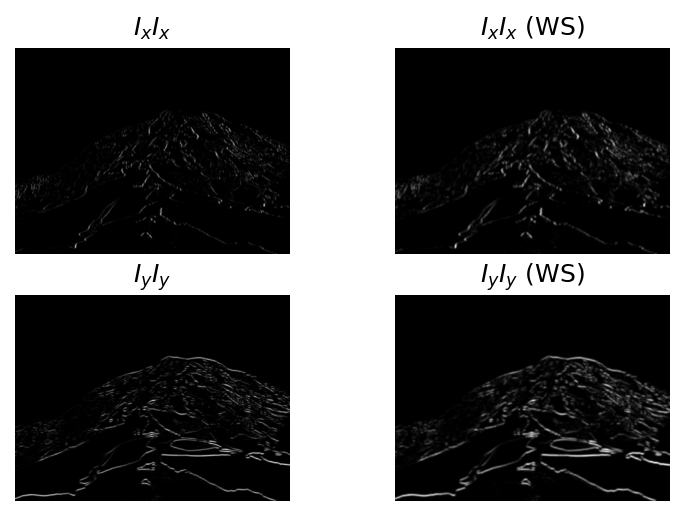

In [9]:
f, axes = pl.subplots(2,2,dpi=150)
axes[0,0].imshow(np2img(IxIx,True,True))
axes[0,0].axis(False)
axes[0,0].set_title('$I_{x}I_{x}$')
axes[0,1].imshow(np2img(IxIx_ws,True,True))
axes[0,1].axis(False)
axes[0,1].set_title('$I_{x}I_{x}$ (WS)')

axes[1,0].imshow(np2img(IyIy,True,True))
axes[1,0].axis(False)
axes[1,0].set_title('$I_{y}I_{y}$')
axes[1,1].imshow(np2img(IyIy_ws,True,True))
axes[1,1].axis(False)
axes[1,1].set_title('$I_{y}I_{y}$ (WS)');

Next process in the pipeline is to calculate Harris "cornerness" response $R$ as estimate of the 2nd eigenvalue: det($S$)- $\alpha$ trace($S$)$^2$, $\alpha = .06$. We need to set thresholds on the response map to identify corners, edges, and other features. Setting such thresholds is not an easy task but we can always use some herustics.

[min(R), max(R)] = [-0.357 0.365]


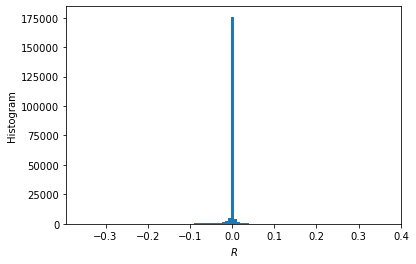

In [10]:
alpha = 0.06
R = (IxIx_ws * IyIy_ws - IxIy_ws**2) - alpha * (IxIx_ws + IyIy_ws)**2
print('[min(R), max(R)] = [{:.3f} {:.3f}]'.format(R.min(), R.max()))
n, bins, patches = pl.hist(R.flatten(), 100)
pl.xlabel('$R$')
pl.ylabel('Histogram')
thresh_edge = -0.1
thresh_corner = 0.1

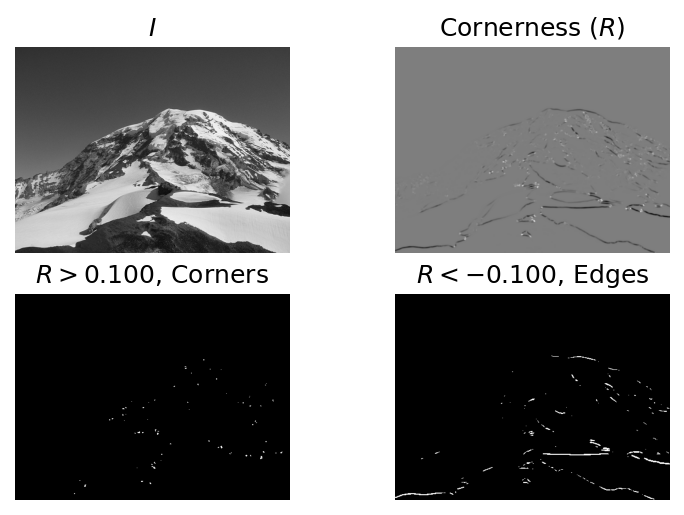

In [11]:
f, axes = pl.subplots(2,2,dpi=150)
axes[0,0].imshow(np2img(I, False, True))
axes[0,0].axis(False)
axes[0,0].set_title('$I$')
axes[0,1].imshow(np2img(R, True, True))
axes[0,1].axis(False)
axes[0,1].set_title('Cornerness ($R$)')

axes[1,0].imshow(np2img((R>thresh_corner)*1.0, True, True))
axes[1,0].axis(False)
axes[1,0].set_title('$R > {0:.3f}$, Corners'.format(thresh_corner))
axes[1,1].imshow(np2img((R<thresh_edge)*1.0, True, True))
axes[1,1].axis(False)
axes[1,1].set_title('$R < {0:.3f}$, Edges'.format(thresh_edge));

The final stage of the Harris corner detection is to run non-max suppression on the response map $R$. The non-max suppression simply operates by suppressing the pixels which are not maximum within their $w \times w$ neighborhood. Note that $w$ must be an odd natural number.

In [12]:
w = 5
w = w // 2
w = 1 if w == 0 else w
corners = []
for y in range(w, R.shape[0]-w):
    for x in range(w, R.shape[1]-w):
        if R[y,x] >= thresh_corner:
            if (R[y-w:y+w+1,x-w:x+w+1] > R[y,x]).sum() == 0:
                corners.append([x,y])

Now we can display the detected corners on the input RGB image.

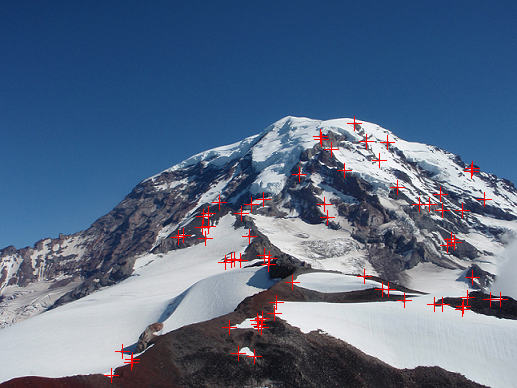

In [13]:
RGB_corners = draw_corners(RGB, corners)
display(RGB_corners)

Corners are marked with the crosses. They seem pretty sensible! Lots of corners near where snow meets rock and such. Try playing with the different threshold values to see how they affect our corner detector. Now, we can put everything into one function `detect_corners(...)`.

In [14]:
def detect_corners(im, sigma=1, thresh=0.1, alpha=0.06, w=5):
    """
    This function detects and returns the spatial locations of the corners in the 
    input 2D image object im using the Harris corner detection pipeline. See above for 
    the definitions of the parameters.
    """
    B = gaussian_kernel(sigma=1.0, dim=2)
    G = gaussian_kernel(sigma, dim=2)
    Sx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Sy = Sx.copy().T
    # Blur image
    IB = imfilter(im, B)
    # Calculate image derivatives
    Ix = imfilter(IB, Sx)
    Iy = imfilter(IB, Sy)
    # Calculate three measures
    IxIx = Ix * Ix
    IyIy = Iy * Iy
    IxIy = Ix * Iy
    # Calculate three measures with weighted sums
    IxIx = imfilter(IxIx, G)
    IyIy = imfilter(IyIy, G)
    IxIy = imfilter(IxIy, G)
    # Calculate cornerness response
    R = (IxIx * IyIy - IxIy**2) - alpha * (IxIx + IyIy)**2
    # Apply non-maximum suppression and find the list of corners
    w = 5
    w = w // 2
    w = 1 if w == 0 else w
    keypoints = []
    for y in range(w, R.shape[0]-w):
        for x in range(w, R.shape[1]-w):
            if R[y,x] >= thresh:
                if (R[y-w:y+w+1,x-w:x+w+1] > R[y,x]).sum() == 0:
                    keypoints.append([x,y])
    
    return np.array(keypoints)

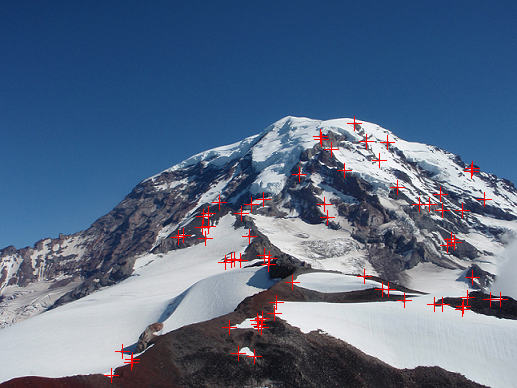

In [15]:
RGB_corners = Image.open('../data/Rainier1.png').convert('RGB')
F = np.array([[[0.299, 0.587, 0.114]]])
I = imfilter(RGB, F) / 255.0

keypoints = detect_corners(I, sigma=1.0, thresh=0.1, alpha=0.06, w=5)
RGB_corners = draw_corners(RGB, keypoints)
display(RGB_corners)

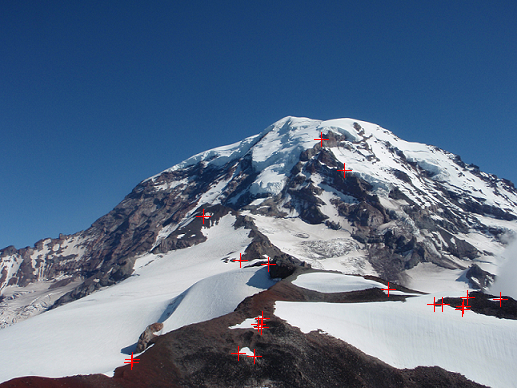

In [16]:
keypoints = detect_corners(I, sigma=1.0, thresh=0.2, alpha=0.06, w=5)
RGB_corners = draw_corners(RGB, keypoints)
display(RGB_corners)

### Your Task [40 Marks]

By changing the parameters of the Harris corner detector `detect_corners(...)`, analyse the impact of change in parameter values on the detector's performance and provide a short report here.

## Corner (Keypoint) Descriptor

In order to match corners (or keypoints) in between images, we need a descriptor for each keypoint. A descriptor is nothing but a representation of keypoint based on its neighborhood, i.e., $w \times w$ neighborhood in this work. We can employ different types of representations, even embeddings from famous convolutional neural networks. The following function is one of the simplest descriptors we can use for this purpose.

In [17]:
def describe_corners(im, keypoints, w=5):
    """
    This function returns a descriptor for each input corner based on its w x w neighborhood on the input image objec im.
    """
    im = np.array(im).astype(float)
    w = w // 2
    w = 1 if w == 0 else w
    b = np.zeros((2*w+1, 2*w+1), dtype=np.int8)
    b[w, w] = 1
    b = (b == 0)
    descriptors = []
    for keypoint in keypoints:
        descriptor = im[keypoint[1]-w:keypoint[1]+w+1, keypoint[0]-w:keypoint[0]+w+1]
        descriptor = descriptor - im[keypoint[1],keypoint[0]]
        descriptors.append(descriptor[b].flatten())

    return np.array(descriptors)

In [18]:
descriptors = describe_corners(RGB, keypoints=keypoints, w=5)

## Corner (Keypoint) Matching


To get a panorama, we must match the corner detections with their appropriate counterpart in the other image. The descriptor code is already written for you. It consists of nearby pixels except with the centre pixel value subtracted. This gives us a small amount of invariance to lighting conditions. 

### Distance Metric



For comparing keypoints, we'll use L1 distance. As we saw in class, squared error (L2 distance) can be problematic with outliers. We don't want a few rogue pixels to throw off our matching function. L1 distance (sum absolute difference) better behaves with some outliers. 

In [19]:
def descriptor_distance(d1, d2, distance_type='L2'):
    """
    This function computes and returns distance between the 1D vector d1 and 2D array d2.
    """
    distance = []
    if distance_type == 'L2':
        distance = np.sqrt(((d2 - d1)**2).sum(axis=1))
    elif distance_type == 'L1':
        distance = np.sqrt(((d2 - d1)**2).sum(axis=1))

    return distance

### Find Matches between Two Images

First we'll look through descriptors (`descriptors1`) for image $I_{1}$ and find their best match with descriptors (`descriptors2`) for image $I_{2}$. 

In [20]:
def match_descriptors(descriptors1, descriptors2, distance_type='L2'):
    """
    This function matches each descriptor of descriptors1 with the closest descriptor in descriptors2.
    """
    matches = []
    distances = []
    for i, descriptor1 in enumerate(descriptors1):
        distance = descriptor_distance(descriptor1, descriptors2, distance_type=distance_type)
        j = np.argmin(distance)
        matches.append([i, j])
        distances.append(distance[j])
    
    matches = np.array(matches)
    distances = np.array(distances)

    return matches, distances

In [21]:
def find_and_draw_matches(im1, im2, sigma=1, thresh=0.1, 
    alpha=0.06, w=5, distance_type='L2', 
    line_width=3, line_color=(255, 0, 0), cross_color=(0,255,128)):
    """
    This function finds and draws best matches between the keypoints of im1 and im2.
    """
    F = np.array([[[0.299, 0.587, 0.114]]])
    I1 = imfilter(im1, F) / 255.0
    I2 = imfilter(im2, F) / 255.0

    keypoints1 = detect_corners(I1, sigma=sigma, thresh=thresh, alpha=alpha, w=w)
    keypoints2 = detect_corners(I2, sigma=sigma, thresh=thresh, alpha=alpha, w=w)

    descriptors1 = describe_corners(im1, keypoints1, w=w)
    descriptors2 = describe_corners(im2, keypoints2, w=w)

    matches, distances = match_descriptors(descriptors1, descriptors2, distance_type=distance_type)
    
    im12 = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)), color=(255, 255, 255))
    im12.paste(draw_corners(im1,keypoints1,line_width=line_width,color=cross_color), (0, 0))
    im12.paste(draw_corners(im2,keypoints2,line_width=line_width,color=cross_color), (im1.width, 0))
    draw = ImageDraw.Draw(im12)
    for match in matches:
        left = keypoints1[match[0]].tolist()
        right = (keypoints2[match[1]] + np.array([im1.width, 0])).tolist()
        draw.line(left + right, fill=line_color, width=line_width)

    return im12

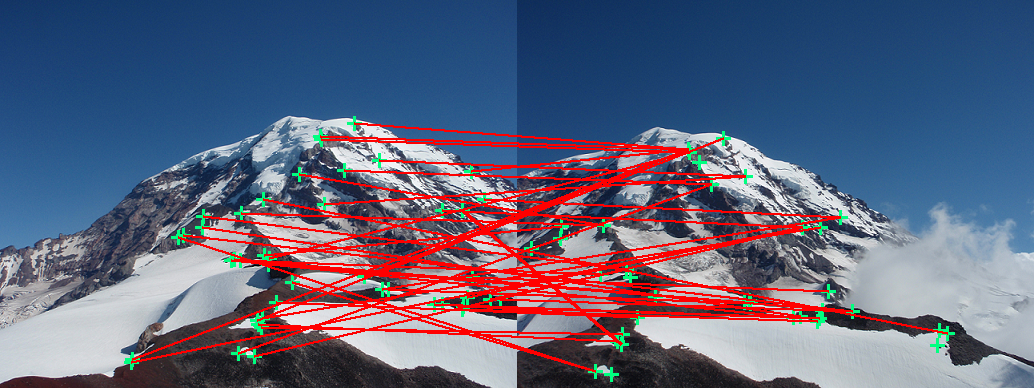

In [22]:
sigma = 1
thresh = 0.15
alpha = 0.06
w = 5
distance_type = 'L2'
RGB1 = Image.open('../data/Rainier1.png').convert('RGB')
RGB2 = Image.open('../data/Rainier2.png').convert('RGB')
RGB12_matches = find_and_draw_matches(RGB1, RGB2, sigma, thresh, alpha, w, distance_type)
display(RGB12_matches)

Each descriptor in $I_{1}$ will only appear in one match. But several of them may match with the same descriptor in $I_{2}$. This can be problematic. Namely, if a bunch of matches go to the same point there is an easy homography to estimate that just shrinks the whole image down to one point to project from $I_{1}$ to $I_{2}$. But we know that's wrong. So let's just get rid of these duplicate matches and make our matches be one-to-one.

To do this, sort the matches based on distance so shortest distance is first. Next, loop through the matches in order and keep track of which elements in $I_{2}$ we've seen. If we see one for a second (or third, etc.) time, throw it out! This can be done with a single pass through the data. Once this is done we can show the matches we discover between the images.

The following script should produce the image below it.

    sigma = 1
    thresh = 0.15
    alpha = 0.06
    w = 5
    distance_type = 'L2'
    RGB1 = Image.open('../data/Rainier1.png').convert('RGB')
    RGB2 = Image.open('../data/Rainier2.png').convert('RGB')
    RGB12_matches = find_and_draw_matches(RGB1, RGB2, sigma, thresh, alpha, w, distance_type)
    display(RGB12_matches)

![Rainier1Rainier2L2OneToOne](../figs/Rainier1Rainier2L2OneToOne.png)

The following script with correct implementation of `descriptor_distance(...)` should produce the image below it.

    sigma = 1
    thresh = 0.15
    alpha = 0.06
    w = 5
    distance_type = 'L1'
    RGB1 = Image.open('../data/Rainier1.png').convert('RGB')
    RGB2 = Image.open('../data/Rainier2.png').convert('RGB')
    RGB12_matches = find_and_draw_matches(RGB1, RGB2, sigma, thresh, alpha, w, distance_type)
    display(RGB12_matches)

![Rainier1Rainier2L1OneToOne](../figs/Rainier1Rainier2L1OneToOne.png)


### Your Task [60 Marks]

The implementations of `descriptor_distance(...)` and `find_and_draw_matches(...)` either have bugs in it or are incomplete. Fix the bugs and complete the implementations to produce the outputs above.

# Submission

Answer the questions, zip your entire folder and submit it on Canvas under Assignment 3